In [1]:
import os
import pickle
from os.path import join
from tifffile import imread
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from ultrack.imgproc import normalize
from ultrack.utils.array import array_apply

In [3]:
cwd = os.getcwd()

In [4]:
file = Path("./input/demo.tif")
config_id = 1

In [5]:
experiment = Path(file).stem
data_dir = Path(join(cwd, "output", experiment))
input_file = Path(join(cwd, "input", file.name))


In [6]:
normalized_path = data_dir / "normalized.npy"
cellpose_path = data_dir / "cellpose_labels.npy"
wscp_path = data_dir / "wscp_labels.npy"
stardist_path = data_dir / "stardist_labels.npy"
wssd_path = data_dir / "wssd_labels.npy"
detection_path = data_dir / f"{config_id}" / "detections.npz"
tracks_path = data_dir / f"{config_id}" / "tracks.pkl"
track_label_path = data_dir / f"{config_id}" / "track_labels.npy"
graph_path = data_dir / f"{config_id}" / "graph.pkl"

In [7]:
with open(graph_path, "rb") as f:
    graph = pickle.load(f)

In [8]:
image = imread(input_file)

In [9]:
image = image[:, 1:, :, :]
image = np.swapaxes(image, 1, 3)

In [10]:
normalized = np.zeros(image.shape, dtype=np.float16)
array_apply(
    image,
    out_array=normalized,
    func=normalize,
    gamma=1,
    axis=(0, 3),
)

Applying normalize ...:  35%|███▌      | 7/20 [00:00<00:01, 11.08it/s]

Applying normalize ...: 100%|██████████| 20/20 [00:01<00:00, 12.18it/s]


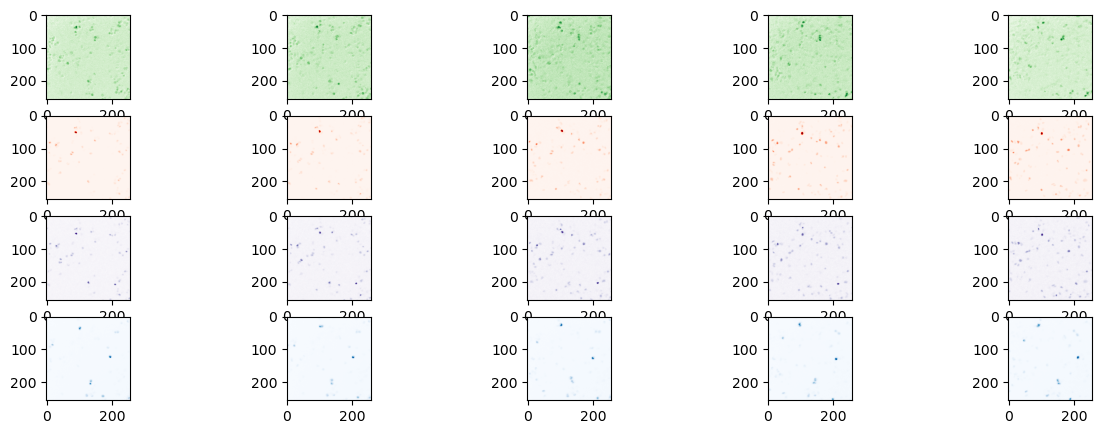

In [11]:
fig, ax = plt.subplots(4, 5, figsize=(15, 5))
for time in range(image.shape[0]):
    ax[0, time].imshow(normalized[time, :256, :256, 0], cmap="Greens")
    ax[1, time].imshow(normalized[time, :256, :256, 1], cmap="Reds")
    ax[2, time].imshow(normalized[time, :256, :256, 2], cmap="Purples")
    ax[3, time].imshow(normalized[time, :256, :256, 3], cmap="Blues")

In [12]:
tracks_df = pd.read_pickle(tracks_path)

In [13]:
track_labels = np.load(track_label_path)

In [14]:
BLUE_FLAG = (image.shape[1] > 4)

In [15]:
tracks_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id
id,,,,,,,
1000001,1,0,3.0,461.0,1000001,-1,-1
2000006,1,1,4.0,454.0,2000006,-1,1000001
3000002,1,2,3.0,445.0,3000002,-1,2000006
4000005,1,3,4.0,444.0,4000005,-1,3000002
5000028,1,4,5.0,438.0,5000028,-1,4000005
1000002,2,0,13.0,463.0,1000002,-1,-1
2000004,2,1,12.0,462.0,2000004,-1,1000002
3000005,2,2,9.0,458.0,3000005,-1,2000004
4000013,2,3,7.0,463.0,4000013,-1,3000005


In [16]:
def invert_graph(graph):
    inverse_graph = {}
    for key, value in graph.items():
        if value in inverse_graph.keys():
            inverse_graph[value].append(key)
        else:
            inverse_graph[value] = [key]
    return inverse_graph

In [17]:
graph

{189: 188,
 190: 188,
 235: 234,
 236: 234,
 384: 383,
 385: 383,
 438: 437,
 439: 437,
 542: 541,
 543: 541,
 643: 642,
 644: 642,
 659: 658,
 660: 658,
 777: 776,
 778: 776,
 1060: 1059,
 1061: 1059}

In [19]:
def get_lines(tracks_df, graph):
    all_tracks = tracks_df["track_id"].unique()

    igraph = invert_graph(graph)

    all_tracks = all_tracks[
        np.isin(all_tracks, np.array(list(graph.keys())), invert=True)
    ]

    def recurse_tracks(all_tracks, parent=None):
        for track_id in all_tracks:
            track = tracks_df[tracks_df["track_id"] == track_id]
            if parent is not None:
                track = pd.concat([parent, track])

            if track_id in igraph.keys():
                yield from recurse_tracks(igraph[track_id], track)
            else:
                yield track

    yield from recurse_tracks(all_tracks)

In [20]:
def get_single_line(track_id, tracks_df, graph):
    for track in get_lines(tracks_df, graph):
        if track_id in track["track_id"].values:
            return track

In [21]:
len(tracks_df)

5503

In [22]:
def populate_cell_intensities(image, track_labels, tracks_df):
    """Get the mean of the intensity of each channel for each track.

    Args:
            image (np.ndarray): numpy array of the image of the shape
                    (time, channels, h, w)
            track_labels (np.ndarray): an numpy array of labels generated
                    by ultrack
            tracks_df (pd.DataFrame): tracks dataframe from ultracks analysis

    Returns:
            pd.DataFrame: tracks dataframe merged with average intensities for
                    each cell
    """
    columns = ["green_intensity", "red_intensity", "farred_intensity"]
    if BLUE_FLAG:
        columns.append("blue_intensity")
    intensities = pd.DataFrame(columns=columns, index=tracks_df.index)

    def compute_intensities(row):
        time = int(row["t"])

        track_mask = track_labels[time] == row["track_id"]
        inten_dict = {
            "green_intensity": np.mean(image[time, :, :, 0][track_mask]),
            "red_intensity": np.mean(image[time, :, :, 1][track_mask]),
            "farred_intensity": np.mean(image[time, :, :, 2][track_mask]),
        }
        if BLUE_FLAG:
            inten_dict["blue_intensity"] = np.mean(image[time, :, :, 3][track_mask])

        return pd.Series(inten_dict)

    intensities = tracks_df.apply(compute_intensities, axis=1)

    tracks_df = pd.merge(tracks_df, intensities, left_index=True, right_index=True)

    return tracks_df

In [23]:
track_intensity_df = populate_cell_intensities(normalized, track_labels, tracks_df)

In [24]:
track_intensity_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id,green_intensity,red_intensity,farred_intensity,blue_intensity
id,,,,,,,,,,,
1000001,1,0,3.0,461.0,1000001,-1,-1,0.259521,0.097961,0.162842,0.007240
2000006,1,1,4.0,454.0,2000006,-1,1000001,0.274414,0.081909,0.159790,0.008301
3000002,1,2,3.0,445.0,3000002,-1,2000006,0.244141,0.066833,0.129883,0.006760
4000005,1,3,4.0,444.0,4000005,-1,3000002,0.206055,0.010094,0.074463,0.007477
5000028,1,4,5.0,438.0,5000028,-1,4000005,0.178467,0.052429,0.114868,0.008156
1000002,2,0,13.0,463.0,1000002,-1,-1,0.343994,0.070190,0.186157,0.022324
2000004,2,1,12.0,462.0,2000004,-1,1000002,0.344971,0.081055,0.214844,0.020599
3000005,2,2,9.0,458.0,3000005,-1,2000004,0.288330,0.090637,0.198120,0.013557
4000013,2,3,7.0,463.0,4000013,-1,3000005,0.232910,0.091858,0.191284,0.014801


In [25]:
def get_intensity_graph(single_intensity_track):
    """Generates a line graph of the intensity of each channel. Also
    indicates when the track was split.

    TODO: Format graph. Normalize y value (might need to change the function call to do this).

    Args:
            single_intensity_track (pd.DataFrame): a subset of the
                    track_intensity_df which contains a single track line.
                    Must contain intensity columns.
    """
    time = single_intensity_track.t
    green_intensity = single_intensity_track.green_intensity
    red_intensity = single_intensity_track.red_intensity
    farred_intensity = single_intensity_track.farred_intensity
    if BLUE_FLAG:
        blue_intensity = single_intensity_track.blue_intensity

    separation_points = []
    lines = single_intensity_track.track_id.unique()

    for line_idx in lines:
        line = single_intensity_track[single_intensity_track["track_id"] == line_idx]
        if line.iloc[0]["parent_id"] == -1:
            continue
        else:
            separation_points.append(min(line.t))

    plt.plot(time, green_intensity, label="green", color="green")
    plt.plot(time, red_intensity, label="red", color="red")
    plt.plot(time, farred_intensity, label="farred", color="purple")
    if BLUE_FLAG:
        plt.plot(time, blue_intensity, label="blue", color="blue")
    plt.vlines(
        separation_points,
        ymin=0,
        ymax=max(
            green_intensity.max(),
            red_intensity.max(),
            farred_intensity.max(),
            blue_intensity.max() if BLUE_FLAG else 0,
        ),
        color="black",
    )

In [26]:
def get_tracking_images(image, track_labels, single_track, padding=10):
    """Gets a list of images of each cell in the track
    for each channel.

    **or**

    Generates a list of images of each cell in the track
    for each channel.

    Args:
            image (np.ndarray): numpy array of the image of the
                    shape (time, channels, h, w)
            single_track (pd.DataFrame): a subset of tracks_df
                    containing a single track line.
    """
    channels = image.shape[3] + 1
    total_time = len(single_track)
    fig, ax = plt.subplots(channels, total_time, figsize=(15, 5))

    for cell in single_track.itertuples():
        time = cell.t

        track_mask_idx = np.where(track_labels[time] == cell.track_id)
        track_mask = track_labels[time] == cell.track_id
        xbounds = (track_mask_idx[0].min() - padding, track_mask_idx[0].max() + padding)
        xbounds = (int(max(0, xbounds[0])), int(min(image.shape[1], xbounds[1])))
        ybounds = (track_mask_idx[1].min() - padding, track_mask_idx[1].max() + padding)
        ybounds = (int(max(0, ybounds[0])), int(min(image.shape[2], ybounds[1])))

        ax[0][time].imshow(
            track_mask[xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]], cmap="gray"
        )
        ax[1][time].imshow(
            image[time, :, :, 0][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Greens",
        )
        ax[2][time].imshow(
            image[time, :, :, 1][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Reds",
        )
        ax[3][time].imshow(
            image[time, :, :, 2][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Purples",
        )
        if BLUE_FLAG:
            ax[4][time].imshow(
                image[time, :, :, 3][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
                cmap="Blues",
            )

    plt.show()

In [27]:
def get_track_lengths(tracks_df, graph):
	for track in get_lines(tracks_df, graph):
		yield (track.track_id, len(track))

In [28]:
i = 1
for track in get_lines(track_intensity_df, graph):
    # i -= 1
    # if i == 0:
    # 	single_track = track
    # 	break
    if len(track["track_id"].unique()) > 1:
        i -= 1
        if i == 0:
            single_track = track
            break

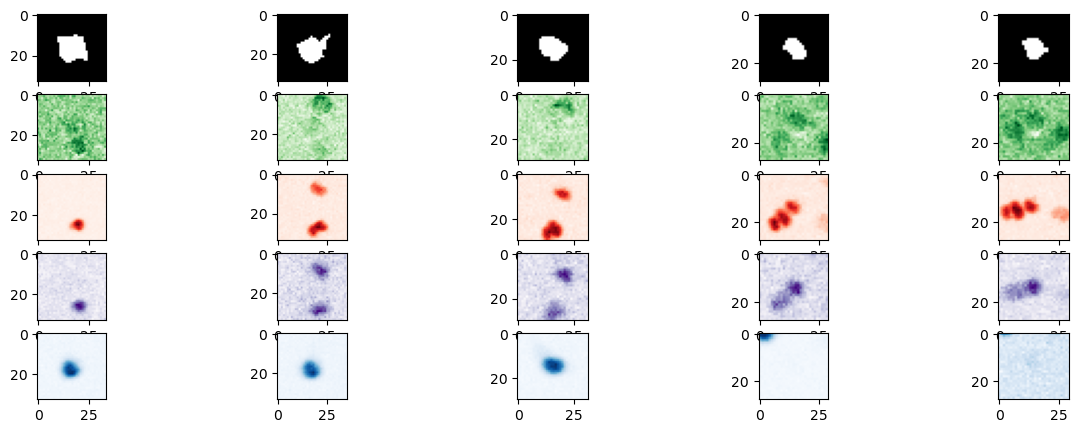

In [29]:
get_tracking_images(normalized, track_labels, single_track, padding=10)

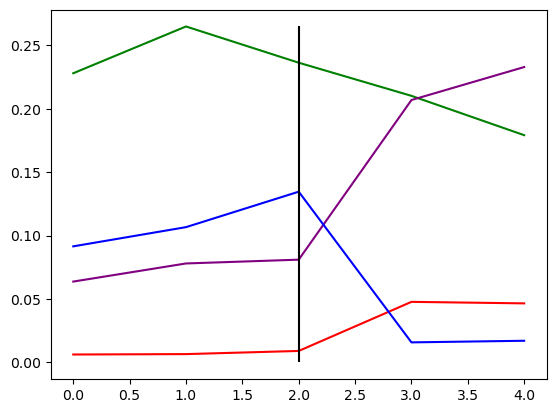

In [30]:
get_intensity_graph(single_track)

In [134]:
def get_average_intensity_graph(tracks_df, graph):
    """Get the average intensity over all tracks with time
            offset to the last split for each track.

    Args:
            tracks_df (pd.DataFrame): DataFrame of all tracks
            graph (dict): dictionary generated from ultrack
                    with track hiearchy.
    """
    offset_df = pd.DataFrame(columns=tracks_df.columns)
    for single_track in get_lines(tracks_df, graph):
        last_split_time = 0
        lines = single_track.track_id.unique()

        for line_idx in lines:
            line = single_track[single_track["track_id"] == line_idx]
            if line.iloc[0]["parent_id"] == -1:
                continue
            else:
                if min(line.t) > last_split_time:
                    last_split_time = min(line.t)

        single_track.loc[:, "t"] = single_track["t"].sub(last_split_time)
        offset_df = pd.concat([offset_df, single_track])

    time_groups = offset_df.groupby(by="t")

    offset_df_means = time_groups.mean(numeric_only=True)
    offset_df_std = time_groups.std(numeric_only=True)
    offset_df_len = time_groups.count()

    plt.plot(
        offset_df_means.index,
        offset_df_means["green_intensity"],
        label="green",
        color="green",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["green_intensity"]
        - 1.96
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        offset_df_means["green_intensity"]
        + 1.96
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        alpha=0.2,
        color="green",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["red_intensity"],
        label="red",
        color="red",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["red_intensity"]
        - 1.96
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        offset_df_means["red_intensity"]
        + 1.96
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        alpha=0.2,
        color="red",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["farred_intensity"],
        label="farred",
        color="purple",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["farred_intensity"]
        - 1.96
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        offset_df_means["farred_intensity"]
        + 1.96
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        alpha=0.2,
        color="purple",
    )

    if BLUE_FLAG:
        plt.plot(
            offset_df_means.index,
            offset_df_means["blue_intensity"],
            label="blue",
            color="blue",
        )
        plt.fill_between(
            offset_df_means.index,
            offset_df_means["blue_intensity"]
            - 1.96
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            offset_df_means["blue_intensity"]
            + 1.96
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            alpha=0.2,
            color="blue",
        )

    plt.vlines(
        0,
        ymin=0,
        ymax=max(
            offset_df_means["green_intensity"].max(),
            offset_df_means["red_intensity"].max(),
            offset_df_means["farred_intensity"].max(),
            offset_df_means["blue_intensity"].max() if BLUE_FLAG else 0,
        ),
        color="black",
    )

/tmp/ipykernel_1250/2209527294.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  offset_df = pd.concat([offset_df, single_track])


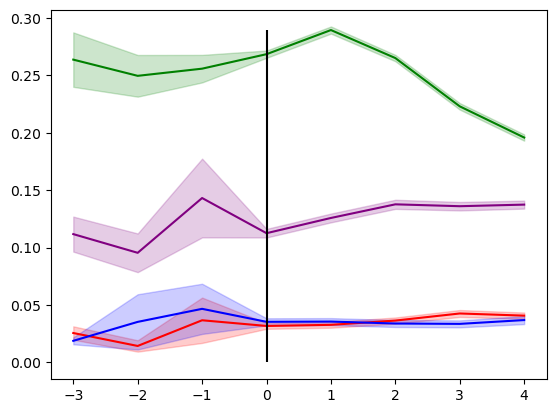

In [135]:
get_average_intensity_graph(track_intensity_df, graph)